<a href="https://colab.research.google.com/github/nataliariera/regresion_avanzada/blob/main/Caso_practico_RLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [S1] Introducción y carga de datos


**Importación de librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, normal_ad
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

from scipy.stats import shapiro


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Data Science/Student_Performance.csv')
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


## [S2] Preparación del modelo (X, y, dummies)

**Preparación del dataset**

In [ ]:
df = data.copy()

# Definir la columna objetivo
y_col = "Performance Index"   # tu target

# Chequear que exista
print(df.columns)   # debería listar todas, incluida 'Performance Index'


Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')


In [ ]:
# Paso 2 - Preparación de datos

# Copia del dataframe original
df_clean = data.copy()

# Definir la variable respuesta (y) y las predictoras (X)
y = df_clean["Performance Index"]
X = df_clean.drop(columns=["Performance Index"])

# One-hot encoding para la variable categórica 'Extracurricular Activities'
X = pd.get_dummies(X, drop_first=True)

# Revisar las primeras filas para confirmar
print(X.head())
print(y.head())


   Hours Studied  Previous Scores  Sleep Hours  \
0              7               99            9   
1              4               82            4   
2              8               51            7   
3              5               52            5   
4              7               75            8   

   Sample Question Papers Practiced  Extracurricular Activities_Yes  
0                                 1                            True  
1                                 2                           False  
2                                 2                            True  
3                                 2                            True  
4                                 5                           False  
0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
Name: Performance Index, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- 0) YA tengo df_clean, X, y (del Paso 2) ---

# 1) DIAGNÓSTICO RÁPIDO
print("Tipos de X antes:", X.dtypes)
print("Tipo de y:", y.dtype)
print("Columnas object en X:", list(X.select_dtypes(include="object").columns))

#Esto es importante porque statsmodels.OLS solo acepta números; si alguna columna sigue siendo object (ej. texto “Yes/No”), se rompe

# 2) ARREGLAR TIPOS + NaN
# (a) asegurar numéricos (si algo quedó como texto se fuerza a numérico)
X_num = X.apply(pd.to_numeric, errors="coerce")
y_num = pd.to_numeric(y, errors="coerce")
print("Tipos de X después:", X_num.dtypes)
print("Tipo de y después:", y_num.dtype)

#Qué hace: intenta convertir todas las columnas a números.Si alguna celda no se puede convertir, se reemplaza por NaN

# (b) quitar filas con NaN (en X o y)
mask = X_num.notna().all(axis=1) & y_num.notna()
X_num = X_num.loc[mask].copy()
y_num = y_num.loc[mask].copy()

#Qué hace: elimina filas que tienen valores perdidos (NaN), tanto en X como en y

# (c) eliminar columnas constantes o vacías (si quedó alguna)
const_cols = [c for c in X_num.columns if X_num[c].nunique() <= 1]
if const_cols:
    X_num.drop(columns=const_cols, inplace=True)

Tipos de X antes: Hours Studied                       int64
Previous Scores                     int64
Sleep Hours                         int64
Sample Question Papers Practiced    int64
Extracurricular Activities_Yes       bool
dtype: object
Tipo de y: float64
Columnas object en X: []
Tipos de X después: Hours Studied                       int64
Previous Scores                     int64
Sleep Hours                         int64
Sample Question Papers Practiced    int64
Extracurricular Activities_Yes       bool
dtype: object
Tipo de y después: float64


## [S3] Ajuste inicial (OLS)



Objetivo: dejar X/y 100% numéricos, sin NaN ni columnas constantes, para que statsmodels.OLS funcione bien.

Por qué: si queda algo tipo object o con NaN, OLS tira el error “Pandas data cast to numpy dtype of object”.

Resultado: ols.summary() listo para interpretar.

In [ ]:
# 3) AJUSTE
X_const = sm.add_constant(X_num, has_constant='add').astype(float)
ols = sm.OLS(y_num.astype(float), X_const).fit()
print(ols.summary())

#Agrega intercepto: sm.add_constant(...) mete la constante β₀ en el modelo.
#Convierte a float para asegurarse que todo está en formato numérico.
#Ajusta el modelo con sm.OLS(...).fit().
#Muestra el resumen con coeficientes, R², AIC, BIC, significancia, etc.


                            OLS Regression Results                            
Dep. Variable:      Performance Index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.757e+05
Date:                Sat, 13 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:49:38   Log-Likelihood:                -21307.
No. Observations:               10000   AIC:                         4.263e+04
Df Residuals:                    9994   BIC:                         4.267e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   


**Bondad de ajuste (R², F-test).**

Tiene buen nivel de explicabilidad, el test global indica que el modelo completo es altamente significativo.
En el test individual vemos que todos los coeficientes son significativos.

**Durbin Watson** cercano a 2 lo cual indica que no hay correlación en los residuos.

Para testear normalidad usamos **Omnibus test y Jarque Bera**. Ambos test están basados en asimetría y curtosis. La hipotesis nula es que los residuos siguen distribución normal y en ambos casos no se rechaza la H0. No hay evidencia de que los residuos se aparten de la normalidad.

EL valor de **skew** (asimetría) es muy cercano a cero, con lo cual los residuos son muy simétricos. Además la **Kurtosis** es cercana a 3, lo cual indica que los residuos tienen cola y formas muy parecidas a la normal.
La distribución de los residuos es aproximadamente normal.

EL valor **Cond.No**, condition number mide cuán cerca de singular o mal condicionada está esa matriz. Una matriz mal condicionada significa que algunas variables explicativas están fuertemente correlacionadas lo cual indica posible multicolinealidad.

Cond. No. < 30 → en general no hay problemas.

30 – 100 → hay señales de colinealidad moderada.

> 100 → colinealidad fuerte

## [S4] Validación de supuestos (linealidad, VIF, homocedasticidad, normalidad, independencia)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Paso 4 - Calcular VIF y Tolerancia

# Usamos la misma X_const que empleaste para OLS (incluye el intercepto)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]
vif_data["Tolerancia"] = 1 / vif_data["VIF"]

print(vif_data)


                           Variable        VIF  Tolerancia
0                             const  38.916475    0.025696
1                     Hours Studied   1.000478    0.999522
2                   Previous Scores   1.000326    0.999674
3                       Sleep Hours   1.000600    0.999400
4  Sample Question Papers Practiced   1.000557    0.999443
5    Extracurricular Activities_Yes   1.000802    0.999199


VIF = 1 → sin colinealidad.

1 < VIF < 5 → colinealidad moderada.

VIF > 10 → colinealidad fuerte (preocupante).

Tolerancia = 1 / VIF → valores bajos (<0.2) indican problemas.

Aqui vemos que el modelo no presenta problemas de multicolinealidad entre predictores.

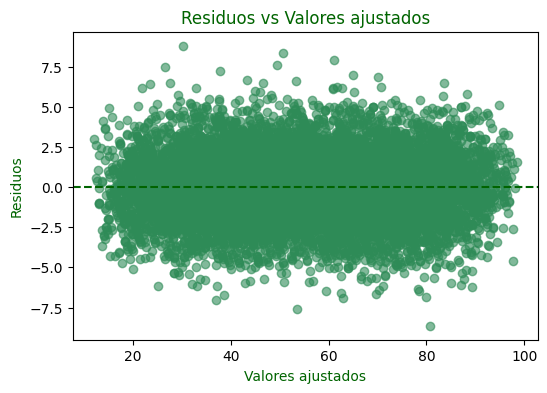

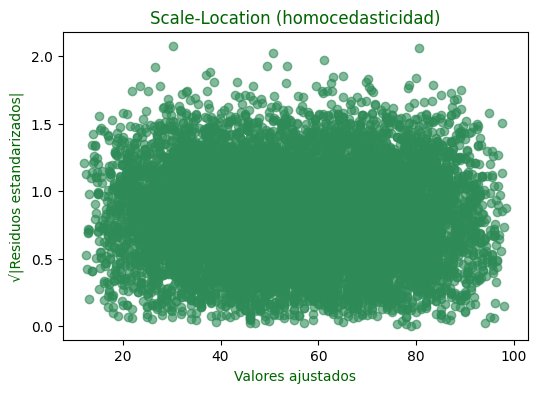

Breusch-Pagan test
LM stat=2.159, p-value=0.827
F stat=0.432, F p-value=0.827

White test
Stat=15.368, p-value=0.699


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Residuos y valores ajustados
resid = ols.resid
fitted = ols.fittedvalues


# 1) Gráfico de residuos vs valores ajustados (linealidad + homocedasticidad)
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.6, c="#2E8B57")  # verde más suave
plt.axhline(0, color="#006400", linestyle="--")     # verde más oscuro
plt.xlabel("Valores ajustados", color="#006400")
plt.ylabel("Residuos", color="#006400")
plt.title("Residuos vs Valores ajustados", color="#006400")
plt.show()

# 2) Scale-Location plot (sqrt de residuos estandarizados vs ajustados)
resid_std = ols.get_influence().resid_studentized_internal
plt.figure(figsize=(6,4))
plt.scatter(fitted, np.sqrt(np.abs(resid_std)), alpha=0.6, c="#2E8B57")
plt.xlabel("Valores ajustados", color="#006400")
plt.ylabel("√|Residuos estandarizados|", color="#006400")
plt.title("Scale-Location (homocedasticidad)", color="#006400")
plt.show()

# 3) Test de Breusch-Pagan
bp_test = het_breuschpagan(resid, ols.model.exog)
print("Breusch-Pagan test")
print(f"LM stat={bp_test[0]:.3f}, p-value={bp_test[1]:.3f}")
print(f"F stat={bp_test[2]:.3f}, F p-value={bp_test[3]:.3f}")

# 4) Test de White
white_test = het_white(resid, ols.model.exog)
print("\nWhite test")
print(f"Stat={white_test[0]:.3f}, p-value={white_test[1]:.3f}")


**Residuos vs Valores ajustados**

La nube está dispersa y centrada alrededor de 0, sin patrón en forma de cono ni curva.

Esto sugiere que se cumple el supuesto de linealidad y varianza constante. ✔️

**Scale-Location plot**

La dispersión de los puntos es bastante homogénea a lo largo del rango de valores ajustados.

No se ve que la nube se “abra” ni “estreche” → evidencia de homocedasticidad. ✔️

Según los Test de Breusch Pagan y White Test, no se rechaza la H0 de homocedasticidad. Por tanto el modelo cumple con el supuesto de linealidad y homocedasticidad.

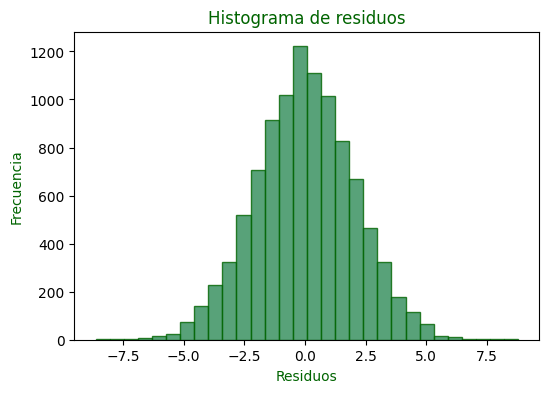

/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


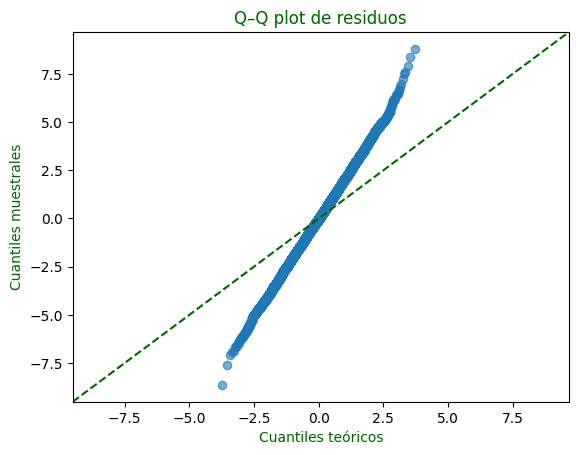

Dataset > 5000 filas → Shapiro no recomendado (muy sensible).
Anderson–Darling: stat=0.410, p-value≈0.344
Jarque–Bera: stat=4.036, p-value=0.133, skew=0.013, kurt=3.095


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import jarque_bera  # <- acá está el JB correcto

# Residuos del modelo
resid = ols.resid

# 1) Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30, edgecolor="#006400", color="#2E8B57", alpha=0.8)  # tonos verdes
plt.title("Histograma de residuos", color="#006400")
plt.xlabel("Residuos", color="#006400")
plt.ylabel("Frecuencia", color="#006400")
plt.show()

# 2) Q–Q plot
fig = sm.qqplot(resid, line="45", color="#2E8B57", alpha=0.6)  # puntos verdes
plt.title("Q–Q plot de residuos", color="#006400")
plt.xlabel("Cuantiles teóricos", color="#006400")
plt.ylabel("Cuantiles muestrales", color="#006400")

# Línea de referencia en verde oscuro
line = plt.gca().lines[1]
line.set_color("#006400")
line.set_linestyle("--")

plt.show()

# 3) Shapiro-Wilk (solo recomendable si n <= 5000)
if len(resid) <= 5000:
    sh_stat, sh_p = shapiro(resid)
    print(f"Shapiro-Wilk: stat={sh_stat:.3f}, p-value={sh_p:.3f}")
else:
    print("Dataset > 5000 filas → Shapiro no recomendado (muy sensible).")

# 4) Anderson–Darling
ad_stat, ad_p = normal_ad(resid)
print(f"Anderson–Darling: stat={ad_stat:.3f}, p-value≈{ad_p:.3f}")

# 5) Jarque–Bera
jb_stat, jb_p, skew, kurt = jarque_bera(resid)
print(f"Jarque–Bera: stat={jb_stat:.3f}, p-value={jb_p:.3f}, skew={skew:.3f}, kurt={kurt:.3f}")


El histograma tiene forma de campana centrado en 0, y el qq plot muestra que los residuos siguen la normalidad en el centro, con ligeras desviaciones en las colas. Esto es común en muestras grandes. Los tests de Jarque–Bera y Anderson–Darling confirman que no rechazamos la hipótesis de normalidad, por lo que el supuesto puede considerarse cumplido.

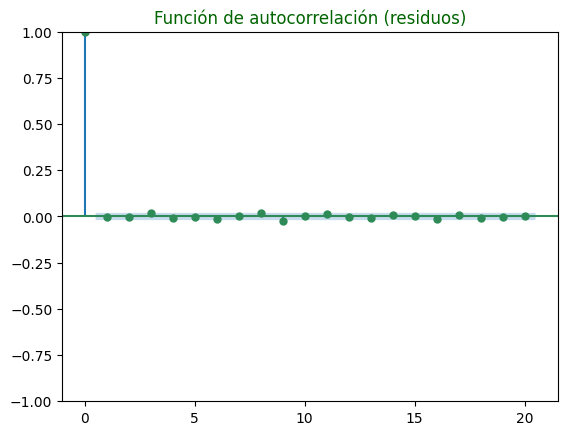

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(resid, lags=20, color="#2E8B57")
plt.title("Función de autocorrelación (residuos)", color="#006400")
plt.show()

Hasta aquí, hemos validado todos los supuestos del Modelo RLM.

El modelo de regresión lineal múltiple ajustado sobre el dataset cumple de manera adecuada con los supuestos clásicos: linealidad, homocedasticidad, independencia, ausencia de multicolinealidad y normalidad de residuos.
👉 Esto respalda la validez de las inferencias (significancia de coeficientes e intervalos de confianza).

🔹 Linealidad: residuos sin patrón → ✔️

🔹 Homocedasticidad: Breusch–Pagan y White p > 0.05 → ✔️

🔹 Independencia: Durbin–Watson ≈ 2 → ✔️

🔹 Multicolinealidad: VIF ≈ 1 → ✔️

🔹 Normalidad: Q–Q plot aceptable, JB y AD no rechazan → ✔️

👉 Conclusión: el modelo cumple los supuestos clásicos y es confiable para la interpretación. ✅

## [S5] Selección de variables

Best Subset Selection

Forward Selection

Backward Elimination

Stepwise (mixto)

In [ ]:
pip install mlxtend


In [ ]:
# Asegurar que X e y son numéricos
X_clean = X.apply(pd.to_numeric, errors="coerce")
y_clean = pd.to_numeric(y, errors="coerce")

# Eliminar filas con NaN (si las hubiera)
mask = X_clean.notna().all(axis=1) & y_clean.notna()
X_clean = X_clean.loc[mask].copy()
y_clean = y_clean.loc[mask].copy()

# Confirmar tipos
print(X_clean.dtypes)
print(y_clean.dtype)


Hours Studied                       int64
Previous Scores                     int64
Sleep Hours                         int64
Sample Question Papers Practiced    int64
Extracurricular Activities_Yes       bool
dtype: object
float64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools

# ===== Preparación de datos =====
df = data.copy()

# Variable respuesta
y_final = df["Performance Index"]

# Predictores
X_final = df.drop(columns=["Performance Index"])

# Convertir categóricas a dummies
X_final = pd.get_dummies(X_final, drop_first=True)

# Asegurar que todo sea numérico
X_final = X_final.apply(pd.to_numeric, errors="coerce")
y_final = pd.to_numeric(y_final, errors="coerce")

# Reemplazar inf por NaN y eliminar filas con NaN
X_final = X_final.replace([np.inf, -np.inf], np.nan)
mask = X_final.notna().all(axis=1) & y_final.notna()
X_final = X_final.loc[mask].astype(float)
y_final = y_final.loc[mask].astype(float)

print("Tipos en X_final:", X_final.dtypes.unique())
print("Shape final:", X_final.shape, y_final.shape)

# ===== Función para ajustar y devolver métricas =====
def fit_metrics(X, y, features):
    Xc = sm.add_constant(X[list(features)], has_constant='add').astype(float)
    m  = sm.OLS(y.astype(float), Xc).fit()
    return {"model": m, "AIC": m.aic, "BIC": m.bic, "R2_adj": m.rsquared_adj, "k": len(features)}

# ===== Métodos de selección =====
def best_subset(X, y):
    rows=[]; cols=list(X.columns)
    for k in range(1, len(cols)+1):
        for combo in itertools.combinations(cols, k):
            met = fit_metrics(X, y, combo)
            rows.append({"vars": combo, "AIC": met["AIC"], "BIC": met["BIC"], "R2_adj": met["R2_adj"]})
    df = pd.DataFrame(rows)
    return tuple(df.sort_values("AIC").iloc[0]["vars"]), tuple(df.sort_values("BIC").iloc[0]["vars"])

def forward_selection(X, y):
    remaining=set(X.columns); selected=[]; best_aic=np.inf
    while remaining:
        cand = min(((fit_metrics(X, y, selected+[c])["AIC"], c) for c in remaining), key=lambda t:t[0])
        if cand[0] + 1e-9 < best_aic:
            selected.append(cand[1]); remaining.remove(cand[1]); best_aic=cand[0]
        else: break
    return tuple(selected)

def backward_elimination(X, y):
    features=list(X.columns); cur=fit_metrics(X, y, features)["AIC"]
    changed=True
    while changed and len(features)>1:
        changed=False
        aics=[(fit_metrics(X, y, [f for f in features if f!=c])["AIC"], c) for c in features]
        best_aic, drop=min(aics, key=lambda t:t[0])
        if best_aic + 1e-9 < cur:
            features.remove(drop); cur=best_aic; changed=True
    return tuple(features)

def stepwise_selection(X, y):
    included=[]; cur=np.inf
    while True:
        changed=False
        # Forward
        excluded=list(set(X.columns)-set(included))
        if excluded:
            aics=[(fit_metrics(X, y, included+[c])["AIC"], c) for c in excluded]
            best_aic, add=min(aics, key=lambda t:t[0])
            if best_aic + 1e-9 < cur: included.append(add); cur=best_aic; changed=True
        # Backward
        if included:
            aics=[(fit_metrics(X, y, [c for c in included if c!=col])["AIC"], col) for col in included]
            best_aic_b, drop=min(aics, key=lambda t:t[0])
            if best_aic_b + 1e-9 < cur: included.remove(drop); cur=best_aic_b; changed=True
        if not changed: break
    return tuple(included)

# ===== Ejecutar las 4 técnicas =====
best_aic_vars, best_bic_vars = best_subset(X_final, y_final)
forward_vars  = forward_selection(X_final, y_final)
backward_vars = backward_elimination(X_final, y_final)
stepwise_vars = stepwise_selection(X_final, y_final)



Tipos en X_final: [dtype('float64')]
Shape final: (10000, 5) (10000,)


## [S6] Comparación de modelos

In [ ]:
# ===== Resumen =====
def metrics(features):
    m=fit_metrics(X_final, y_final, features)
    return m["AIC"], m["BIC"], m["R2_adj"], m["k"], m["model"]

summary = {
  "BestSubset_AIC": metrics(best_aic_vars),
  "BestSubset_BIC": metrics(best_bic_vars),
  "Forward_AIC":    metrics(forward_vars),
  "Backward_AIC":   metrics(backward_vars),
  "Stepwise_AIC":   metrics(stepwise_vars),
}

# === Variables seleccionadas por método ===
all_vars = list(X_final.columns)
table = pd.DataFrame({"Variable": all_vars})
for name, feats in {
    "BestSubset_AIC": best_aic_vars,
    "BestSubset_BIC": best_bic_vars,
    "Forward_AIC":    forward_vars,
    "Backward_AIC":   backward_vars,
    "Stepwise_AIC":   stepwise_vars,
}.items():
    table[name] = table["Variable"].isin(feats)

print("\n=== Variables seleccionadas por metodo ===")
print(table.to_string(index=False))

# === Métricas por método ===
metrics_df = pd.DataFrame({
    'Metodo': list(summary.keys()),
    'AIC': [summary[k][0] for k in summary],
    'BIC': [summary[k][1] for k in summary],
    'R2_ajustado': [summary[k][2] for k in summary],
    'k_predictores': [summary[k][3] for k in summary]
})

# Hacé el sort en una línea aparte para evitar problemas de comillas
metrics_df = metrics_df.sort_values(by=['BIC', 'AIC']).reset_index(drop=True)

print("\n=== Metricas por metodo ===")
print(metrics_df.to_string(index=False))

winner = metrics_df.loc[0, 'Metodo']
print(f"\n=== Summary del modelo ganador ({winner}) ===")
print(summary[winner][4].summary())



=== Variables seleccionadas por metodo ===
                        Variable  BestSubset_AIC  BestSubset_BIC  Forward_AIC  Backward_AIC  Stepwise_AIC
                   Hours Studied            True            True         True          True          True
                 Previous Scores            True            True         True          True          True
                     Sleep Hours            True            True         True          True          True
Sample Question Papers Practiced            True            True         True          True          True
  Extracurricular Activities_Yes            True            True         True          True          True

=== Metricas por metodo ===
        Metodo          AIC          BIC  R2_ajustado  k_predictores
BestSubset_AIC 42625.108017 42668.370059     0.988747              5
BestSubset_BIC 42625.108017 42668.370059     0.988747              5
   Forward_AIC 42625.108017 42668.370059     0.988747              5
  Backward_AIC 

Todos los métodos eligen las mismas 5 variables y devuelven métricas de AIC, BIC, R2 ajustado prácticamente iguales.
El summary del modelo confirma que todos los coeficientes son significativos y tiene un ajuste excelente.

Los cuatro métodos coinciden en que el mejor modelo incluye todas las variables disponibles. Por lo tanto, el modelo completo es el más parsimonioso en este dataset.



## [S7] Validación predictiva

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Modelo lineal con sklearn
lr = LinearRegression()

# 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular RMSE (neg_mean_squared_error devuelve valores negativos)
mse_scores = cross_val_score(lr, X_final, y_final, cv=cv, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-mse_scores)

print("RMSE por fold:", rmse_scores)
print("RMSE promedio:", rmse_scores.mean())
print("Desvío estándar:", rmse_scores.std())


RMSE por fold: [2.02055151 2.07253517 2.02561553 2.03015061 2.04537845]
RMSE promedio: 2.038846252543422
Desvío estándar: 0.018777522353622043


RMSE por fold: error en cada partición.

RMSE promedio: el error esperado del modelo al generalizar.

Desvío estándar: cuán estable es la predicción entre particiones.

RMSE por fold: todos alrededor de 2.02 – 2.08.

RMSE promedio ≈ 2.03 → error de predicción muy bajo.

Desvío estándar ≈ 0.018 → el error es muy consistente entre folds, lo que indica estabilidad.

**Esto confirma que el modelo no solo ajusta muy bien en entrenamiento (R² ≈ 0.989), sino que también generaliza con precisión en validación cruzada.**

## [S8] Conclusiones


- Supuestos: ✅ linealidad, ✅ homocedasticidad, ✅ independencia (DW≈2), ✅ normalidad (JB/AD), ✅ VIF bajo.

- Selección de variables: los 4 métodos coinciden → modelo estable y parsimonioso.

- Métricas: R²_aj ~ 0.989; AIC/BIC mínimos con todas las variables.

- Predicción: RMSE CV ~ 2 (bajo y estable).
